# **Sentiment Analisis Aplikasi Playstore Studi Kasus Gopay**
**Naive Bayes dan Support Vector Machine (SVM)**

**LSTM, CNN, GRU, BiLSTM, dan DNN menggunakan RandomizedSearchCV**

Data yang digunakan berjumlah 12.000

##**1. Persiapan**

In [44]:
# Instalasi modul yang diperlukan
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. Memuat dan Membersihkan Data**

In [45]:
# Memuat data ulasan dari file CSV
csv_file_path = '/content/drive/My Drive/Colab Notebooks/SUBMISION/gopayreviews.csv'
df = pd.read_csv(csv_file_path)

# Menampilkan informasi ringkas tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12500 non-null  object
 1   userName              12500 non-null  object
 2   userImage             12500 non-null  object
 3   content               12500 non-null  object
 4   score                 12500 non-null  int64 
 5   thumbsUpCount         12500 non-null  int64 
 6   reviewCreatedVersion  10224 non-null  object
 7   at                    12500 non-null  object
 8   replyContent          1575 non-null   object
 9   repliedAt             1575 non-null   object
 10  appVersion            10224 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [46]:
def clean_text(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Menghapus kata dengan 1-2 huruf
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Menghapus karakter non-alfabet
    text = text.lower()                       # Mengubah menjadi huruf kecil
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df['label'] = df['score'].apply(label_sentiment)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_content'])
X_padded = pad_sequences(X_seq, maxlen=100)

# Menghitung Bobot Kelas
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Membagi Data Menjadi 85% Training dan 15% Testing
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, y, test_size=0.15, random_state=42)


# Tampilkan sample Baris Data
df.head()

Class Weights: {0: 2.2293561619404314, 1: 10.936132983377078, 2: 0.4065040650406504}


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_content,label
0,d49949da-d9a7-400c-93c1-a73b4e491686,Agoez Ahmad,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantap dan Ok Banget ❤️👍🫰,5,0,NaN,2024-08-09 14:28:37,NaN,NaN,NaN,mantap dan banget,positif
1,e9c9d00e-55a4-41c8-a257-387afea1bb55,Kurnia Wandi,https://play-lh.googleusercontent.com/a/ACg8oc...,Praktis dan cepat,5,0,1.28.0,2024-08-09 14:27:33,NaN,NaN,1.28.0,praktis dan cepat,positif
2,f793671b-e5b3-4a38-837a-8da3faf43278,Irwan Saputra,https://play-lh.googleusercontent.com/a/ACg8oc...,Lebih canggih dan aman,5,0,1.27.0,2024-08-09 14:27:01,NaN,NaN,1.27.0,lebih canggih dan aman,positif
3,4d0a7c51-afa8-4671-ae27-cd4e37913539,Idris Copler,https://play-lh.googleusercontent.com/a-/ALV-U...,Makjoss,5,0,1.28.0,2024-08-09 14:26:24,NaN,NaN,1.28.0,makjoss,positif
4,b25d5649-5f8e-42fe-bd72-f003dddf366b,Ade Rusrika,https://play-lh.googleusercontent.com/a/ACg8oc...,Mantap gopay,5,0,1.28.0,2024-08-09 14:24:18,NaN,NaN,1.28.0,mantap gopay,positif


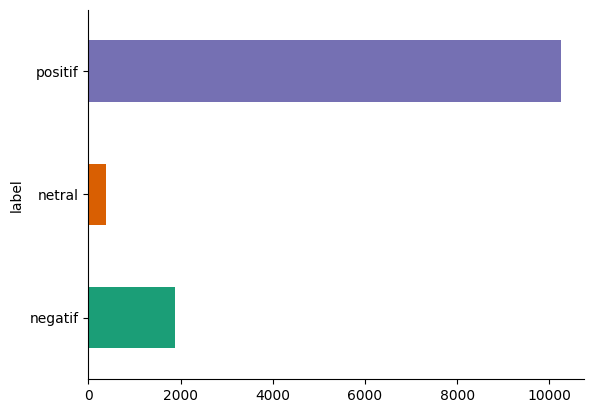

In [47]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## **3. Membuat Model**

**Model LSTM**



In [48]:
embedding_dim = 128
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])
_, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.6388 - loss: 1.0621 - val_accuracy: 0.8494 - val_loss: 0.5858
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy: 0.8184 - loss: 0.8292 - val_accuracy: 0.8456 - val_loss: 0.6168
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - accuracy: 0.8228 - loss: 0.6807 - val_accuracy: 0.8499 - val_loss: 0.5126
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.8482 - loss: 0.5777 - val_accuracy: 0.8052 - val_loss: 0.5748
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 36s 272ms/step - accuracy: 0.8397 - loss: 0.4622 - val_accuracy: 0.8362 - val_loss: 0.5550
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.8672 - loss: 0.4065 - val_accuracy: 0.7906 - val_loss: 0.6357
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - accuracy: 0.8720 - loss: 0.3658 - val_accuracy: 0.8362 - val_loss: 0.5670
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.8867 - loss: 0.3357 - val

**Model CNN**

In [49]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
cnn_model.add(Conv1D(128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])
_, cnn_accuracy = cnn_model.evaluate(X_test_padded, y_test)
print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.4954 - loss: 1.0593 - val_accuracy: 0.8626 - val_loss: 0.7129
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.8514 - loss: 0.8095 - val_accuracy: 0.8409 - val_loss: 0.6840
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8617 - loss: 0.5635 - val_accuracy: 0.8320 - val_loss: 0.5699
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9264 - loss: 0.3549 - val_accuracy: 0.8311 - val_loss: 0.5880
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9195 - loss: 0.3206 - val_accuracy: 0.8358 - val_loss: 0.5669
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8368 - loss: 0.7280
CNN Accuracy: 85.49%


**Model GRU**

In [50]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(GRU(128, dropout=0.3, recurrent_dropout=0.3))
gru_model.add(Dense(3, activation='softmax'))

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_history = gru_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])
_, gru_accuracy = gru_model.evaluate(X_test_padded, y_test)
print(f'GRU Accuracy: {gru_accuracy * 100:.2f}%')

Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.7443 - loss: 9417.5566 - val_accuracy: 0.8292 - val_loss: 0.7447
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - accuracy: 0.8375 - loss: 0.8507 - val_accuracy: 0.8127 - val_loss: 0.6629
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.8008 - loss: 264.7453 - val_accuracy: 0.8104 - val_loss: 0.6325
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.8234 - loss: 0.7586 - val_accuracy: 0.7431 - val_loss: 0.6372
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 297ms/step - accuracy: 0.8124 - loss: 35379.7734 - val_accuracy: 0.7774 - val_loss: 0.6141
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7944 - loss: 0.7670
GRU Accuracy: 80.85%


**Model BiLSTM**

In [51]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
bilstm_model.add(SpatialDropout1D(0.3))
bilstm_model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
bilstm_model.add(Dense(3, activation='softmax'))

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_history = bilstm_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])
_, bilstm_accuracy = bilstm_model.evaluate(X_test_padded, y_test)
print(f'BiLSTM Accuracy: {bilstm_accuracy * 100:.2f}%')


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 535ms/step - accuracy: 0.7232 - loss: 1.0128 - val_accuracy: 0.8061 - val_loss: 0.6357
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 546ms/step - accuracy: 0.7474 - loss: 0.8444 - val_accuracy: 0.8155 - val_loss: 0.6207
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 530ms/step - accuracy: 0.7804 - loss: 0.7647 - val_accuracy: 0.8419 - val_loss: 0.5293
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 539ms/step - accuracy: 0.8044 - loss: 0.6304 - val_accuracy: 0.8334 - val_loss: 0.5256
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - accuracy: 0.8509 - loss: 0.4976 - val_accuracy: 0.8494 - val_loss: 0.5336
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.8152 - loss: 0.6623
BiLSTM Accuracy: 81.39%


## **4. Evaluasi dan Pemilihan Model Terbaik**

In [ ]:
# Menampilkan akurasi semua model
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')
print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')
print(f'GRU Accuracy: {gru_accuracy * 100:.2f}%')
print(f'BiLSTM Accuracy: {bilstm_accuracy * 100:.2f}%')

# Memilih model terbaik
best_accuracy = max(lstm_accuracy, cnn_accuracy, gru_accuracy, bilstm_accuracy)
if best_accuracy >= 0.92:
    print(f"Model terbaik dengan akurasi {best_accuracy * 100:.2f}%")
else:
    print("Tidak ada model yang mencapai akurasi 92%")


## **5. Menyimpan Model Terbaik**

In [ ]:
import os

# Membuat directory untuk menyimpan model
model_save_path = f'/content/drive/My Drive/Colab Notebooks/SUBMISION/best_model_{best_model_name}'
os.makedirs(model_save_path, exist_ok=True)

# Menyimpan model dalam format SavedModel
best_model.save(model_save_path)
print(f"Model {best_model_name} saved successfully at {model_save_path}")


**Membuat dan Mengunduh File requirements.txt**

In [ ]:
import subprocess

# Menyimpan library yang digunakan ke dalam file requirements.txt
subprocess.run(["pip", "freeze", ">", "/content/drive/My Drive/Colab Notebooks/SUBMISION/requirements.txt"], shell=True)
print("requirements.txt saved successfully!")


In [ ]:
from google.colab import files

# Mengunduh file requirements.txt
files.download('/content/drive/My Drive/Colab Notebooks/SUBMISION/requirements.txt')